In [ ]:
# Task from:
# https://github.com/machine-intelligence-laboratory/MILTestTasks/tree/task/Pruning

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


DATA_PATH = '../../../../data/torchvision'
transform = transforms.Compose([transforms.Pad(4),
                                transforms.RandomCrop(32),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])
train_dataset = datasets.CIFAR10(DATA_PATH, transform=transform, download=True)
test_dataset = datasets.CIFAR10(DATA_PATH, train=False, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

Files already downloaded and verified


In [2]:
from torch import nn
from torch.nn import functional


def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        if (stride != 1) or (in_channels != out_channels):
            self.downsample = nn.Sequential(conv3x3(in_channels, out_channels, stride=stride),
                                            nn.BatchNorm2d(out_channels))

    def forward(self, x):
        identity = x
        x = self.bn1(self.conv1(x))
        x = self.relu(x)
        x = self.bn2(self.conv2(x))
        if self.downsample is not None:
            identity = self.downsample(identity)
        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):

    def __init__(self, block, n_classes=10):
        super().__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, out_channels=16, stride=1)
        self.layer2 = self._make_layer(block, out_channels=32, stride=2)
        self.layer3 = self._make_layer(block, out_channels=64, stride=2)
        self.fc = nn.Linear(64, n_classes)

    def _make_layer(self, block, out_channels, stride):
        layers = []
        layer = block(self.in_channels, out_channels, stride)
        layers.append(layer)
        self.in_channels = out_channels
        for i in range(2):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.bn(self.conv(x))
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = functional.avg_pool2d(x, x.shape[2:])
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [4]:
import torch
from torch import optim


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet(BasicBlock).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
# images, _ = next(iter(train_loader))
# model(images.to(device))

In [5]:
# total_step = len(train_loader)
# loss_items = []
# for epoch in range(1, 201):
#     for i, (images, labels) in enumerate(train_loader, 1):
#         images, labels = images.to(device), labels.to(device)
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         opt.zero_grad()
#         loss.backward()
#         opt.step()
#         if i % 100 == 0:
#             loss_items.append(loss.item())
#             print (f'Epoch {epoch}, Step {i}/{total_step}, Loss {loss_items[-1]}', end='\r')
#     if epoch % 20 == 0:
#         for param_group in opt.param_groups:
#             param_group['lr'] *= .5

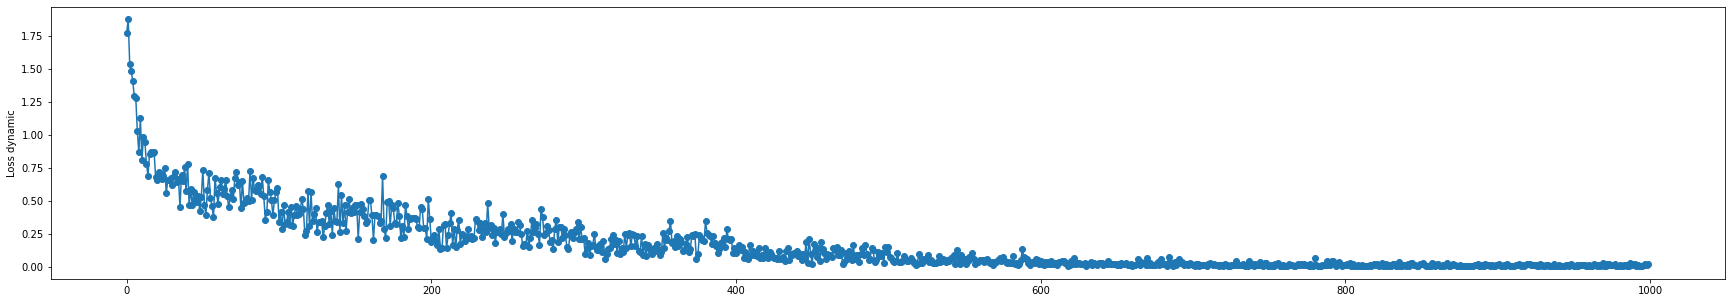

In [6]:
# from matplotlib import pyplot as plt


# plt.figure(figsize=(30, 5))
# plt.ylabel('Loss dynamic')
# plt.plot(range(len(loss_items)), loss_items, marker='o');

In [5]:
def get_accuracy(model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, y_ = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (y_ == labels).sum().item()
        return 100 * correct / total

In [6]:
# Checkpoint
MODEL_PATH = '../../../../models/resnet_20__on__cifar10.ckpt'
# torch.save(model.state_dict(), MODEL_PATH)

In [7]:
model = ResNet(BasicBlock).to(device)
model.load_state_dict(torch.load(MODEL_PATH))
print(f'Accuracy: {get_accuracy(model)}%')

Accuracy: 92.52%


In [8]:
import numpy as np
from sklearn.cluster import KMeans


def update_weights_for(layer, n_clusters):
    weight = layer.conv1.weight
    X = weight.view(layer.conv1.out_channels, -1).detach().cpu().numpy()
    model = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    weight_ = torch.from_numpy(model.cluster_centers_)\
                   .to(device).view(-1, *weight.size()[1:])
    for i, label in enumerate(model.labels_):
        layer.conv1.weight.data[i] = weight_[label]
        if label in model.labels_[:i]:
            model.labels_[i] = -1
    mask = (model.labels_ >= 0)
    return layer, mask


def prune_weights_for(layer, mask):
    active_channels = sum(mask)
    layer.conv1.weight = nn.Parameter(layer.conv1.weight[mask, :, :, :])
    layer.conv1.out_channels = active_channels
    layer.bn1.num_features = active_channels
    layer.bn1.running_mean = layer.bn1.running_mean[mask]
    layer.bn1.running_var = layer.bn1.running_var[mask]
    layer.bn1.weight = nn.Parameter(layer.bn1.weight[mask])
    layer.bn1.bias = nn.Parameter(layer.bn1.bias[mask])
    layer.conv2.in_channels = active_channels
    layer.conv2.weight = nn.Parameter(layer.conv2.weight[:, mask, :, :])

In [9]:
from copy import deepcopy


# model_ = deepcopy(model)
# layer, mask = update_weights_for(model_.layer1[0], 8)
# prune_weights_for(layer, mask)
# model_.layer1[0]

BasicBlock(
  (conv1): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [10]:
accuracy = []
for layer_name in ['layer1', 'layer2', 'layer3']:
    for block_index in range(3):
        batch = []
        for active_channels in range(16, 0, -1):
            model_ = deepcopy(model)
            block = getattr(model_, layer_name)[block_index]
            layer, mask = update_weights_for(block, active_channels)
            prune_weights_for(layer, mask)
            batch.append(get_accuracy(model_))
            print(f'Layer: {layer_name}, Block: {block_index}, Active channels: {active_channels} ', end='\r')
        accuracy.append(batch)
accuracy = np.array(accuracy).T

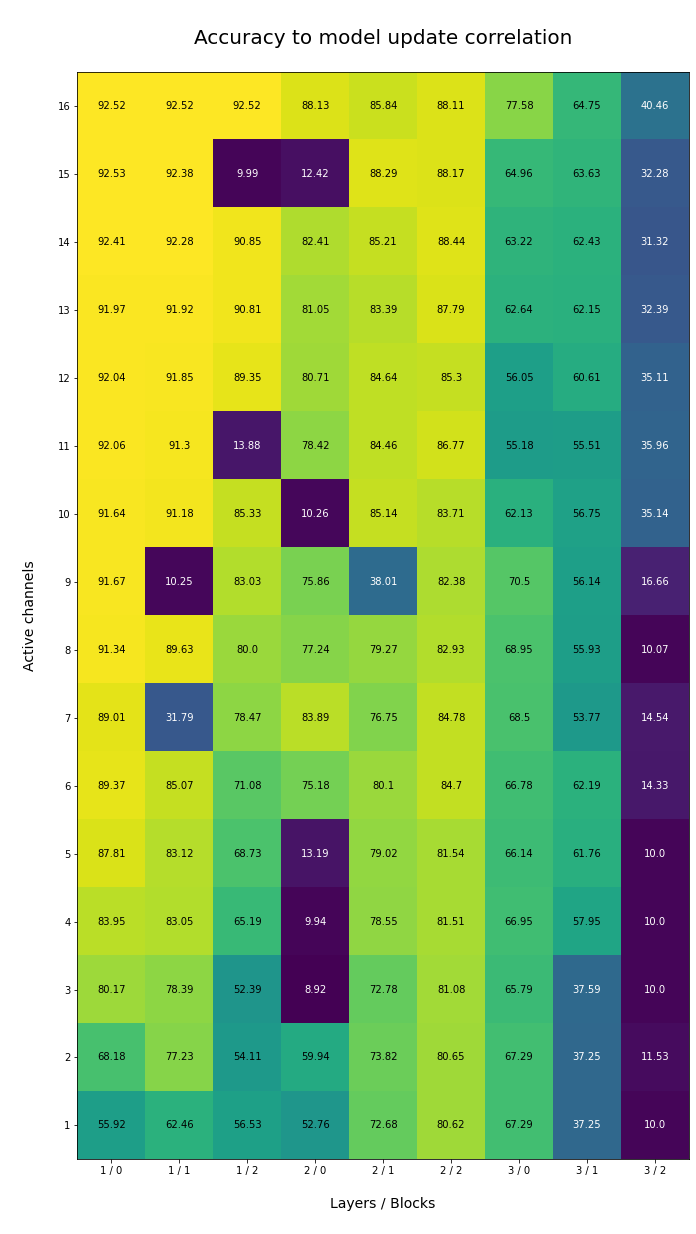

In [12]:
from matplotlib import pyplot as plt


fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(accuracy)
for i in range(accuracy.shape[0]):
    for j in range(accuracy.shape[1]):
        text = ax.text(j, i, accuracy[i, j], ha="center", va="center",
                       color='w' if accuracy[i, j] < 50 else None)
x_labels = [ f'{i} / {j}' for i in range(1, 4) for j in range(3) ]
y_labels = range(16, 0, -1)
ax.set_title('\nAccuracy to model update correlation\n', fontsize=20)
ax.set_ylabel('\nActive channels\n', fontsize=14)
ax.set_xlabel('\nLayers / Blocks\n', fontsize=14)
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels)
ax.set_yticks(range(len(y_labels)))
ax.set_yticklabels(y_labels);